# Pipeline clásico de regresión con Elastic Net

Dataset: `quantbruce/real-estate-price-prediction` (Kaggle).

Objetivos:
- Descargar y cargar los datos.
- Hacer una inspección rápida (tipos, faltantes, distribución).
- Separar en train/test.
- Construir un pipeline con preprocesamiento y `ElasticNetCV`.
- Visualizar el error de CV y la selección de hiperparámetros.
- Interpretar selección de variables y evaluar desempeño.

> Intuición (según las presentaciones): buscamos buen desempeño fuera de muestra, controlando el overfitting con regularización (bias-variance tradeoff).

In [10]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from sklearn.model_selection import train_test_split, KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline # más importante de esta clase

sns.set_theme(style="whitegrid")

In [11]:
import kagglehub

path = kagglehub.dataset_download("quantbruce/real-estate-price-prediction")
print("Path to dataset files:", path)

data_dir = Path(path)
files = sorted([p for p in data_dir.rglob("*") if p.is_file()])
print("Archivos encontrados:")
for p in files:
    print(" -", p.relative_to(data_dir))

Path to dataset files: C:\Users\David\.cache\kagglehub\datasets\quantbruce\real-estate-price-prediction\versions\1
Archivos encontrados:
 - Real estate.csv


In [12]:
csv_files = [p for p in data_dir.rglob("*.csv")]
if not csv_files:
    raise FileNotFoundError("No se encontraron CSV en el dataset.")

print("CSV encontrados:", [p.name for p in csv_files])

# Si hay varios CSV, cambia el índice manualmente.
csv_path = csv_files[0]
print("Usando:", csv_path.name)

df = pd.read_csv(csv_path)
df.head()

CSV encontrados: ['Real estate.csv']
Usando: Real estate.csv


,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


In [13]:
print("Shape:", df.shape)

print("Tipos de datos (conteo):")
display(df.dtypes.value_counts())

print("Resumen estadístico (primeras filas):")
display(df.describe(include="all").transpose().head(20))

print("Faltantes (top 20):")
missing = df.isna().mean().sort_values(ascending=False)
display(missing.head(20))

Shape: (414, 8)
Tipos de datos (conteo):


float64    6
int64      2
Name: count, dtype: int64

Resumen estadístico (primeras filas):


,count,mean,std,min,25%,50%,75%,max
No,414.0,207.500000,119.655756,1.00000,104.250000,207.50000,310.750000,414.00000
X1 transaction date,414.0,2013.148971,0.281967,2012.66700,2012.917000,2013.16700,2013.417000,2013.58300
X2 house age,414.0,17.712560,11.392485,0.00000,9.025000,16.10000,28.150000,43.80000
X3 distance to the nearest MRT station,414.0,1083.885689,1262.109595,23.38284,289.324800,492.23130,1454.279000,6488.02100
X4 number of convenience stores,414.0,4.094203,2.945562,0.00000,1.000000,4.00000,6.000000,10.00000
X5 latitude,414.0,24.969030,0.012410,24.93207,24.963000,24.97110,24.977455,25.01459
X6 longitude,414.0,121.533361,0.015347,121.47353,121.528085,121.53863,121.543305,121.56627
Y house price of unit area,414.0,37.980193,13.606488,7.60000,27.700000,38.45000,46.600000,117.50000


Faltantes (top 20):


No                                        0.0
X1 transaction date                       0.0
X2 house age                              0.0
X3 distance to the nearest MRT station    0.0
X4 number of convenience stores           0.0
X5 latitude                               0.0
X6 longitude                              0.0
Y house price of unit area                0.0
dtype: float64

## Análisis básico de correlación

Una primera mirada útil es ver qué variables numéricas se relacionan más con el precio. Esto no implica causalidad; solo ayuda a construir intuición inicial.

- Correlaciones altas en valor absoluto suelen ser variables más predictivas.
- La correlación no capta relaciones no lineales.

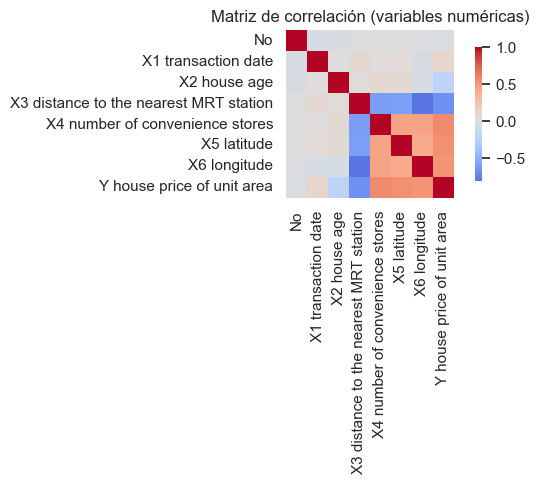

Top correlaciones con el target:


Y house price of unit area                1.000000
X3 distance to the nearest MRT station   -0.673613
X4 number of convenience stores           0.571005
X5 latitude                               0.546307
X6 longitude                              0.523287
X2 house age                             -0.210567
X1 transaction date                       0.087491
No                                       -0.028587
Name: Y house price of unit area, dtype: float64

In [14]:
numeric_cols = df.select_dtypes(include=["number"]).columns
corr = df[numeric_cols].corr()

plt.figure(figsize=(7, 5))
sns.heatmap(corr, cmap="coolwarm", center=0, square=True, cbar_kws={"shrink": 0.8})
plt.title("Matriz de correlación (variables numéricas)")
plt.tight_layout()
plt.show()

# Intento simple de detectar el target para mostrar correlaciones
candidates = [
    c for c in numeric_cols
    if any(k in c.lower() for k in ["price", "target", "value", "precio", "valor"])
]
if candidates:
    target_for_corr = candidates[0]
    corr_target = corr[target_for_corr].sort_values(key=lambda s: s.abs(), ascending=False)
    print("Top correlaciones con el target:")
    display(corr_target.head(10))
else:
    print("No se detectó target para correlaciones. Puedes definir TARGET más abajo.")

## Interpretación de columnas (dataset de precios de vivienda)

Este dataset es el clásico de **Taiwán (real estate valuation)**. Las variables significan:

- `No`: ID de la transacción.
- `X1 transaction date`: fecha de transacción (año con decimales).
- `X2 house age`: edad de la vivienda (años).
- `X3 distance to the nearest MRT station`: distancia a la estación MRT más cercana (metros).
- `X4 number of convenience stores`: número de tiendas de conveniencia cercanas.
- `X5 latitude`: latitud.
- `X6 longitude`: longitud.
- `Y house price of unit area`: **precio por unidad de área** (target).

In [15]:
column_descriptions = {
    "No": "ID de la transacción",
    "X1 transaction date": "Fecha de transacción (año con decimales)",
    "X2 house age": "Edad de la vivienda (años)",
    "X3 distance to the nearest MRT station": "Distancia a la estación MRT más cercana (metros)",
    "X4 number of convenience stores": "Número de tiendas de conveniencia cercanas",
    "X5 latitude": "Latitud",
    "X6 longitude": "Longitud",
    "Y house price of unit area": "Precio por unidad de área (target)",
}

desc_df = pd.DataFrame(
    [(c, column_descriptions.get(c, "(sin descripción)")) for c in df.columns],
    columns=["columna", "descripcion"],
)

display(desc_df)

if "Y house price of unit area" in df.columns:
    print("Sugerencia de TARGET:", "Y house price of unit area")

,columna,descripcion
0,No,ID de la transacción
1,X1 transaction date,Fecha de transacción (año con decimales)
2,X2 house age,Edad de la vivienda (años)
3,X3 distance to the nearest MRT station,Distancia a la estación MRT más cercana (metros)
4,X4 number of convenience stores,Número de tiendas de conveniencia cercanas
5,X5 latitude,Latitud
6,X6 longitude,Longitud
7,Y house price of unit area,Precio por unidad de área (target)


Sugerencia de TARGET: Y house price of unit area


## Nota sobre data leakage

Tal como vimos en clase, toda transformación (estandarización, one-hot, etc.) debe **ajustarse solo con training** y luego aplicarse a test. Por eso usamos un `Pipeline`: evita fugas de información y hace la evaluación más honesta.

In [16]:
TARGET = None  # Cambia manualmente si es necesario


def infer_target(df):
    name_candidates = [
        c for c in df.columns
        if any(k in c.lower() for k in ["price", "target", "value", "precio", "valor"])
    ]
    numeric_candidates = [c for c in name_candidates if pd.api.types.is_numeric_dtype(df[c])]
    if numeric_candidates:
        return numeric_candidates[0]
    raise ValueError(
        "No se pudo inferir la variable objetivo. Asigna TARGET manualmente."
    )


if TARGET is None:
    TARGET = infer_target(df)

print("TARGET seleccionado:", TARGET)

df = df.dropna(subset=[TARGET]).copy()

y = df[TARGET]
X = df.drop(columns=[TARGET])

# El ID de la transacción no es predictivo
if "No" in X.columns:
    X = X.drop(columns=["No"])
    print("Columna 'No' eliminada (ID de transacción)")

numeric_features = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
categorical_features = [c for c in X.columns if c not in numeric_features]

print("Nº features numéricas:", len(numeric_features))
print("Nº features categóricas:", len(categorical_features))

TARGET seleccionado: Y house price of unit area
Columna 'No' eliminada (ID de transacción)
Nº features numéricas: 6
Nº features categóricas: 0


## Pipeline paso a paso (versión didáctica)

1. **Train/Test split**: medimos desempeño en datos no vistos.
2. **Preprocesamiento**: estandarizamos numéricas y hacemos one-hot en categóricas.
3. **Modelo**: `ElasticNetCV` elige la mejor regularización por validación cruzada.
4. **Evaluación**: comparamos RMSE y $R^2$ en train vs. test.

In [ ]:
# 1. Split data: train y test 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42 #random_state es la semilla
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

# 2. estandarizar variables 
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features), #estandarizamos la lista de variables númericas definidas anteriormente
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features), #realizamos OneHotEncoder (hacer dummy una categórica) a la lista de categóricas
    ],
    remainder="drop",
)

# 3. Construcción del modelo
alphas = np.logspace(-4, 2, 30)
l1_ratios = [0.1, 0.5, 0.9, 1.0]

cv = KFold(n_splits=5, shuffle=True, random_state=42)

elastic_cv = ElasticNetCV(
    l1_ratio=l1_ratios, #Grilla de búsqueda de hiperparámetros
    alphas=alphas,
    cv=cv, #cross validation
    max_iter=20000,
    n_jobs=-1,
)

pipe = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", elastic_cv),
    ]
)

pipe

Train size: 331
Test size: 83


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

## Extensión opcional: polinomios (para no-linealidad)

Si crees que la relación no es lineal, puedes incluir términos polinomiales en las **variables numéricas**. Esto aumenta la complejidad (más parámetros), por eso es clave la regularización y la validación cruzada.

Abajo un ejemplo con grado 2.

In [ ]:
# Nota: este bloque es opcional. Cambia degree=2 a 3 si quieres probar.
poly_preprocess = ColumnTransformer(
    transformers=[
        (
            "num",
            Pipeline(
                steps=[
                    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
                    ("scaler", StandardScaler()),
                ]
            ),
            numeric_features,
        ),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ],
    remainder="drop",
)

poly_model = ElasticNetCV(
    l1_ratio=l1_ratios,
    alphas=alphas,
    cv=cv,
    max_iter=20000,
    n_jobs=-1,
)

poly_pipe = Pipeline(
    steps=[
        ("preprocess", poly_preprocess),
        ("model", poly_model),
    ]
)

poly_pipe.fit(X_train, y_train) #entrenamos
poly_test_pred = poly_pipe.predict(X_test) #predecimos


d:\Wuu\Universidad\2026-10\Consultoría Económica con IA\Repositorios\Sandbox_HE2_DavidRodriguez\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.474e+01, tolerance: 5.094e+00
  model = cd_fast.enet_coordinate_descent_gram(
d:\Wuu\Universidad\2026-10\Consultoría Económica con IA\Repositorios\Sandbox_HE2_DavidRodriguez\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.334e+00, tolerance: 4.251e+00
  model = cd_fast.enet_coordinate_descent_gram(
d:\Wuu\Universidad\2026-10\Consultoría Económica con IA\Repositorios\Sandbox_HE2_DavidRodriguez\.venv\Lib\site-packages\sklearn\line

In [25]:
pipe.fit(X_train, y_train)

model = pipe.named_steps["model"]

print("Mejor alpha:", model.alpha_)
print("Mejor l1_ratio:", model.l1_ratio_)


def mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)


def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))


train_pred = pipe.predict(X_train)
test_pred = pipe.predict(X_test)

print("MSE train:", mse(y_train, train_pred))
print("MSE test:", mse(y_test, test_pred))
print("RMSE train:", rmse(y_train, train_pred))
print("RMSE test:", rmse(y_test, test_pred))
print("R2 train:", r2_score(y_train, train_pred))
print("R2 test:", r2_score(y_test, test_pred))

Mejor alpha: 0.04893900918477494
Mejor l1_ratio: 0.1
MSE train: 83.27969879431218
MSE test: 52.97528287216654
RMSE train: 9.125771134228174
RMSE test: 7.278412112004001
R2 train: 0.5572360235886775
R2 test: 0.6842193398442373


## ¿Cómo funciona la selección de variables en Elastic Net?

Elastic Net combina L1 (Lasso) y L2 (Ridge):

- **L1** puede llevar coeficientes exactamente a cero → *selección de variables*.
- **L2** encoge coeficientes pero rara vez los hace cero.

En el código, consideramos seleccionadas las variables con `|coef| > 1e-6` y mostramos el top por magnitud. Es una forma práctica de ver qué entra en el modelo.

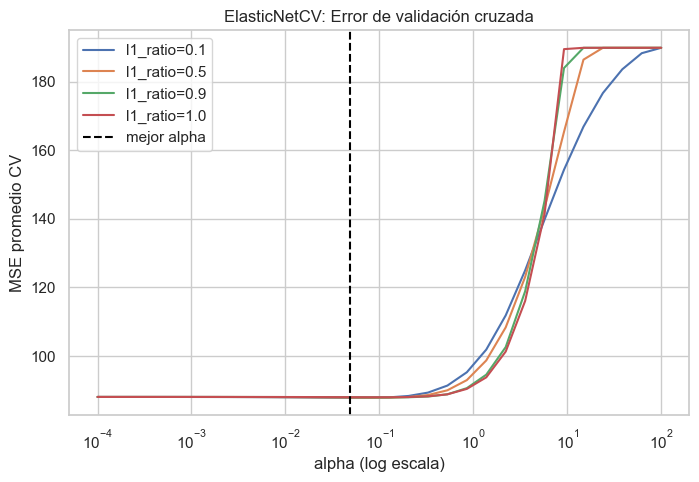

In [20]:
mse_path = model.mse_path_  # shape: (n_l1_ratio, n_alpha, n_folds)
mean_mse = mse_path.mean(axis=2)

l1_ratio_list = model.l1_ratio
if not isinstance(l1_ratio_list, (list, tuple, np.ndarray)):
    l1_ratio_list = [model.l1_ratio_]

plt.figure(figsize=(8, 5))
for i, l1 in enumerate(l1_ratio_list):
    plt.semilogx(model.alphas_, mean_mse[i], label=f"l1_ratio={l1}")

plt.axvline(model.alpha_, color="black", linestyle="--", label="mejor alpha")
plt.xlabel("alpha (log escala)")
plt.ylabel("MSE promedio CV")
plt.title("ElasticNetCV: Error de validación cruzada")
plt.legend()
plt.show()

In [21]:
feature_names = pipe.named_steps["preprocess"].get_feature_names_out()
coefs = model.coef_

coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
coef_df["abs_coef"] = coef_df["coef"].abs()

selected = coef_df[coef_df["abs_coef"] > 1e-6].copy()
print("Variables seleccionadas (coef != 0):", selected.shape[0])

print("Top 20 por |coef|:")
display(selected.sort_values("abs_coef", ascending=False).head(20))

# (Opcional) Re-entrenar sobre variables seleccionadas
preprocessor = pipe.named_steps["preprocess"]
X_train_proc = preprocessor.transform(X_train)
X_test_proc = preprocessor.transform(X_test)

selector = SelectFromModel(model, threshold=1e-6, prefit=True)
X_train_sel = selector.transform(X_train_proc)
X_test_sel = selector.transform(X_test_proc)

final_model = ElasticNet(alpha=model.alpha_, l1_ratio=model.l1_ratio_, max_iter=20000)
final_model.fit(X_train_sel, y_train)

train_pred_sel = final_model.predict(X_train_sel)
test_pred_sel = final_model.predict(X_test_sel)

print("RMSE train (selección):", rmse(y_train, train_pred_sel))
print("RMSE test (selección):", rmse(y_test, test_pred_sel))

Variables seleccionadas (coef != 0): 6
Top 20 por |coef|:


,feature,coef,abs_coef
2,num__X3 distance to the nearest MRT station,-5.136719,5.136719
3,num__X4 number of convenience stores,3.225320,3.225320
1,num__X2 house age,-2.920511,2.920511
4,num__X5 latitude,2.891862,2.891862
0,num__X1 transaction date,1.434563,1.434563
5,num__X6 longitude,0.053670,0.053670


RMSE train (selección): 9.125771134228174
RMSE test (selección): 7.278412112004001


## Interpretación rápida

- Si el RMSE de test es mucho mayor que el de train, hay overfitting.
- Al aumentar `alpha`, la penalización sube y los coeficientes se encogen (más sesgo, menos varianza).
- `l1_ratio` cerca de 1 produce más ceros (selección de variables).

## Polinomios + Elastic Net con selección y re-entrenamiento

En este bloque **sí** usamos polinomios y luego seleccionamos variables con Elastic Net para re-entrenar un modelo más simple.

In [22]:
# Asegurar funciones de error disponibles

def mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)


def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

In [23]:
# Desviación estándar de variables explicativas (X) y del target (Y)
print("Desv. est. de Y (train):", y_train.std())
print("Desv. est. de Y (test):", y_test.std())

if numeric_features:
    X_train_std = X_train[numeric_features].std().sort_values(ascending=False)
    print("Desv. est. de X (train), top 10:")
    display(X_train_std.head(10))

Desv. est. de Y (train): 13.735373081186841
Desv. est. de Y (test): 13.030947588843244
Desv. est. de X (train), top 10:


X3 distance to the nearest MRT station    1217.929569
X2 house age                                11.327281
X4 number of convenience stores              2.953703
X1 transaction date                          0.281570
X6 longitude                                 0.014976
X5 latitude                                  0.012484
dtype: float64

In [24]:
# Polinomios en variables numéricas + Elastic Net
poly_preprocess = ColumnTransformer(
    transformers=[
        (
            "num",
            Pipeline(
                steps=[
                    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
                    ("scaler", StandardScaler()),
                ]
            ),
            numeric_features,
        ),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ],
    remainder="drop",
)

poly_model = ElasticNetCV(
    l1_ratio=l1_ratios,
    alphas=alphas,
    cv=cv,
    max_iter=20000,
    n_jobs=-1,
)

poly_pipe = Pipeline(
    steps=[
        ("preprocess", poly_preprocess),
        ("model", poly_model),
    ]
)

poly_pipe.fit(X_train, y_train)
poly_test_pred = poly_pipe.predict(X_test)

print("MSE test (polinomios):", mse(y_test, poly_test_pred))
print("RMSE test (polinomios):", rmse(y_test, poly_test_pred))

# Selección de variables con Elastic Net y re-entrenamiento
poly_feature_names = poly_pipe.named_steps["preprocess"].get_feature_names_out()
poly_coefs = poly_model.coef_

poly_coef_df = pd.DataFrame({"feature": poly_feature_names, "coef": poly_coefs})
poly_coef_df["abs_coef"] = poly_coef_df["coef"].abs()
selected_poly = poly_coef_df[poly_coef_df["abs_coef"] > 1e-6]

print("Variables seleccionadas (polinomios, coef != 0):", selected_poly.shape[0])
print("Top 20 por |coef| (polinomios):")
display(selected_poly.sort_values("abs_coef", ascending=False).head(20))

poly_preprocessor = poly_pipe.named_steps["preprocess"]
X_train_poly = poly_preprocessor.transform(X_train)
X_test_poly = poly_preprocessor.transform(X_test)

poly_selector = SelectFromModel(poly_model, threshold=1e-6, prefit=True)
X_train_poly_sel = poly_selector.transform(X_train_poly)
X_test_poly_sel = poly_selector.transform(X_test_poly)

poly_final = ElasticNet(alpha=poly_model.alpha_, l1_ratio=poly_model.l1_ratio_, max_iter=20000)
poly_final.fit(X_train_poly_sel, y_train)

poly_train_pred_sel = poly_final.predict(X_train_poly_sel)
poly_test_pred_sel = poly_final.predict(X_test_poly_sel)

print("MSE test (polinomios + selección):", mse(y_test, poly_test_pred_sel))
print("RMSE test (polinomios + selección):", rmse(y_test, poly_test_pred_sel))

d:\Wuu\Universidad\2026-10\Consultoría Económica con IA\Repositorios\Sandbox_HE2_DavidRodriguez\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.151e+01, tolerance: 5.094e+00
  model = cd_fast.enet_coordinate_descent_gram(
d:\Wuu\Universidad\2026-10\Consultoría Económica con IA\Repositorios\Sandbox_HE2_DavidRodriguez\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.578e+02, tolerance: 5.094e+00
  model = cd_fast.enet_coordinate_descent_gram(
d:\Wuu\Universidad\2026-10\Consultoría Económica con IA\Repositorios\Sandbox_HE2_DavidRodriguez\.venv\Lib\site-packages\sklearn\line

MSE test (polinomios): 38.86345378489117
RMSE test (polinomios): 6.2340559658132015
Variables seleccionadas (polinomios, coef != 0): 26
Top 20 por |coef| (polinomios):


d:\Wuu\Universidad\2026-10\Consultoría Económica con IA\Repositorios\Sandbox_HE2_DavidRodriguez\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.259e+02, tolerance: 5.206e+00
  model = cd_fast.enet_coordinate_descent_gram(
d:\Wuu\Universidad\2026-10\Consultoría Económica con IA\Repositorios\Sandbox_HE2_DavidRodriguez\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.779e+01, tolerance: 5.306e+00
  model = cd_fast.enet_coordinate_descent_gram(
d:\Wuu\Universidad\2026-10\Consultoría Económica con IA\Repositorios\Sandbox_HE2_DavidRodriguez\.venv\Lib\site-packages\sklearn\line

,feature,coef,abs_coef
12,num__X2 house age^2,6.417726,6.417726
17,num__X3 distance to the nearest MRT station^2,3.857476,3.857476
18,num__X3 distance to the nearest MRT station X4...,-3.095483,3.095483
15,num__X2 house age X5 latitude,-2.553435,2.553435
16,num__X2 house age X6 longitude,-2.550921,2.550921
1,num__X2 house age,-2.549356,2.549356
7,num__X1 transaction date X2 house age,-2.547764,2.547764
19,num__X3 distance to the nearest MRT station X5...,-2.289856,2.289856
8,num__X1 transaction date X3 distance to the ne...,-2.260617,2.260617
2,num__X3 distance to the nearest MRT station,-2.260120,2.260120


MSE test (polinomios + selección): 38.86346304980765
RMSE test (polinomios + selección): 6.23405670890213
